# Experiment Analysis with Depth Differentiation

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

This version includes depth information in the analysis and uses color saturation to differentiate between different depths.

In [37]:
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# ============================================================================
# CONFIGURATION
# ============================================================================

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')

In [38]:
import datetime


# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict,
                      ) -> bool:
    main_condition = '__PREFIX__' in experiment_parameters and 'ex_04_al' in experiment_parameters['__PREFIX__']
    
    end_time: float = experiment_metadata['end_time']
    end_datetime = datetime.datetime.fromtimestamp(end_time)
    now = datetime.datetime.now()
    max_delta = datetime.timedelta(weeks=2)
    date_condition = (now - end_datetime) <= max_delta

    return main_condition and date_condition


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    
    if '_fp' in experiment.metadata['name']:
        encoding = 'fp'
    elif '_hdc' in experiment.metadata['name']:
        encoding = 'hdc'
    elif '_gnn' in experiment.metadata['name']:
        encoding = 'gnn'
    
    method = experiment.parameters['MODELS'][0]
    num_train = experiment.parameters['NUM_TRAIN']
    
    # Extract depth information based on encoding type
    if 'NUM_LAYERS' in experiment.parameters:
        depth = experiment.parameters['NUM_LAYERS']
    elif 'FINGERPRINT_RADIUS' in experiment.parameters:
        depth = experiment.parameters['FINGERPRINT_RADIUS']
    else:
        depth = 2  # Default depth
    
    return (encoding, method, num_train, depth)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [39]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 34047 experiment archives in 39 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +34044
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [40]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_00_c__17_08_2025__16_08__JXbr" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_e__15_01_2025__09_00__MnVH" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_ad__11_09_2025__20_43__hJiq" - no data found
   ⚠️ Skipping experiment "ex_04_d__06_08_2025__13_15__ja1g" - no data found
   ⚠️ Skipping experiment "hyperopt_b__16_01_2025__08_56__Cv1n" - no data found
   > included experiment "ex_04_al__13_10_2025__12_16__EcwC"
   ⚠️ Skipping experiment "ex_03_b__31_07_2025__11_49__M1Nv" - no data found
   > included experiment "ex_04_al__12_10_2025__19_57__uHUT"
   > included experiment 

In [41]:
example_experiment: Experiment = experiments[0] if experiments else None
pprint(example_experiment.data, max_length=10)

{
│   'indices': {
│   │   'train': [63173, 16953, 5374, 17403, 89720, 101904, 87686, 73573, 35728, 81760, ... +4990],
│   │   'val': [103353, 39439, 118486, 61432, 121965, 65297, 50758, 69676, 20350, 121952, ... +12039],
│   │   'test': [13284, 115942, 123221, 73757, 99596, 34188, 79158, 99569, 38668, 55654, ... +13378]
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [42]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + f'{int(item[0][2]):06d}' + f'{int(item[0][3]):02d}'))
pprint(key_experiment_map, max_length=3)

{
│   ('fp', 'k_neighbors', 10, 1): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c5fdae790>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c5d71bad0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c52a68a10>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 10, 2): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c5ca386d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c5028f990>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c4f8e45d0>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 10, 3): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c5c96ab90>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c56f70090>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7a1c4f7c0290>,
│   │   ... +2
│   ],
│   ... +166
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [43]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Method', 'Depth', 'Num Train', 'Result']

# This data structure will hold the (encoding, method, num_train, depth) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, method, num_train, depth), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'mae'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        method,
        depth,
        num_train,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, method, num_train, depth)] = values
    
print(table.get_string())

+----------+-------------+-------+-----------+-------------+
| Encoding |    Method   | Depth | Num Train |    Result   |
+----------+-------------+-------+-----------+-------------+
|    fp    | k_neighbors |   1   |     10    | 3.18 ± 0.25 |
|    fp    | k_neighbors |   2   |     10    | 3.33 ± 0.15 |
|    fp    | k_neighbors |   3   |     10    | 3.42 ± 0.13 |
|    fp    | k_neighbors |   1   |     50    | 2.68 ± 0.06 |
|    fp    | k_neighbors |   2   |     50    | 2.78 ± 0.05 |
|    fp    | k_neighbors |   3   |     50    | 2.94 ± 0.06 |
|    fp    | k_neighbors |   1   |    100    | 2.62 ± 0.19 |
|    fp    | k_neighbors |   2   |    100    | 2.87 ± 0.36 |
|    fp    | k_neighbors |   3   |    100    | 3.01 ± 0.36 |
|    fp    | k_neighbors |   1   |    250    | 2.53 ± 0.11 |
|    fp    | k_neighbors |   2   |    250    | 2.80 ± 0.30 |
|    fp    | k_neighbors |   3   |    250    | 3.04 ± 0.49 |
|    fp    | k_neighbors |   1   |    500    | 2.43 ± 0.05 |
|    fp    | k_neighbors

defaultdict(<class 'list'>, {
│   ('fp', 1): [
│   │   (10, [3.1763210905197257, 2.956360051811671, 3.4428512086364575, ... +2]),
│   │   (50, [2.6374129639217827, 2.463621934093091, 2.547353428003991, ... +2]),
│   │   (100, [2.40333060861262, 2.5295090277568772, 2.3567381524547266, ... +2]),
│   │   ... +10
│   ],
│   ('fp', 2): [
│   │   (10, [3.164934684876796, 3.4160393380970775, 3.2587175777536563, ... +2]),
│   │   (50, [2.679087947349415, 2.87272021175087, 2.7158836189489506, ... +2]),
│   │   (100, [2.574256849050263, 2.529003159256492, 2.631822623092643, ... +2]),
│   │   ... +10
│   ],
│   ('fp', 3): [
│   │   (10, [3.267740099330809, 3.4294181633767815, 3.1042509954278508, ... +2]),
│   │   (50, [2.7393199153968473, 2.9345531257906137, 2.8198017623341984, ... +2]),
│   │   (100, [2.552782992740325, 2.667534581473753, 2.692847128974258, ... +2]),
│   │   ... +10
│   ],
│   ... +3
})

qm9_heat


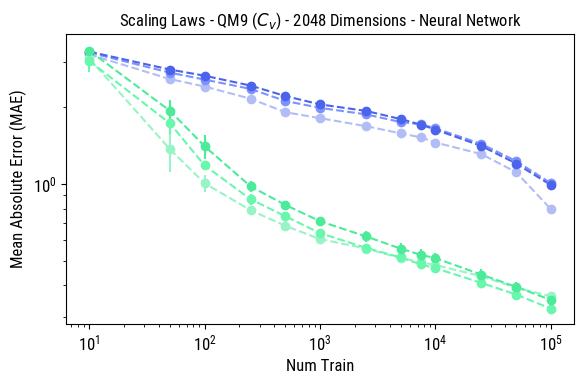

In [44]:
"""
Visualization: Scaling Laws Analysis with Depth Differentiation

This cell creates a log-log plot showing how model performance scales with training set size
for different encoding methods (Fingerprints, GNN, HDC) at different depths.
The plot uses color saturation to differentiate depths:
- Depth 1: Least saturated (lightest)
- Depth 2: Medium saturation
- Depth 3: Most saturated (darkest)
"""
# ============================================================================
# CONFIGURATION
# ============================================================================

# Figure size (width, height) in inches
FIG_SIZE: tuple = (6, 4)

# Font size for all text elements in the plot
FONT_SIZE: int = 12

# Select which model to visualize (e.g., 'neural_net', 'neural_net2', 'random_forest', 'k_neighbors')
MODEL: str = 'neural_net'
#MODEL: str = 'k_neighbors'

LEGEND: bool = False

# ============================================================================
# IMPORTS AND PLOT SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Apply default matplotlib style
plt.style.use('default')

# Use Roboto Condensed font for consistent typography
plt.rcParams['font.family'] = 'Roboto Condensed'

# Configure font sizes for all text elements
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['axes.titlesize'] = FONT_SIZE
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE

# Create figure with appropriate size for publication/presentation
plt.figure(figsize=FIG_SIZE)


# ============================================================================
# VISUAL MAPPINGS: LABELS AND COLORS
# ============================================================================

# Human-readable labels for each (encoding, depth) combination
# These labels will appear in the plot legend
key_label_map = {
    ('fp', 1): 'FP · Depth 1',
    ('fp', 2): 'FP · Depth 2',
    ('fp', 3): 'FP · Depth 3',
    ('gnn', 1): 'GNN · Depth 1',
    ('gnn', 2): 'GNN · Depth 2',
    ('gnn', 3): 'GNN · Depth 3',
    ('hdc', 1): 'HDC · Depth 1',
    ('hdc', 2): 'HDC · Depth 2',
    ('hdc', 3): 'HDC · Depth 3',
}

# Color scheme for different encoding-depth combinations
# Using saturation to differentiate depths within same base color
# Blue shades for Fingerprint methods (most saturated at depth 3)
# Orange shades for GNN methods (most saturated at depth 3)
# Green shades for HDC methods (most saturated at depth 3)
key_color_map = {
    ('fp', 1): '#B2BDF6',          # Light blue for FP depth 1
    ('fp', 2): '#7C92FF',          # Medium blue for FP depth 2
    ('fp', 3): '#4C64EB',          # Deep blue for FP depth 3
    ('gnn', 1): '#F4D4B2',         # Light orange for GNN depth 1
    ('gnn', 2): '#F0B87C',         # Medium orange for GNN depth 2
    ('gnn', 3): '#EBA14C',         # Deep orange for GNN depth 3
    ('hdc', 1): '#99F4C5',         # Light green for HDC depth 1
    ('hdc', 2): '#69F7AE',         # Medium green for HDC depth 2
    ('hdc', 3): '#4CEB99',         # Deep green for HDC depth 3
}


# ============================================================================
# DATA PREPARATION
# ============================================================================

# Group experiments by (encoding, depth), collecting all num_train values and their results
# Filter by the selected MODEL
grouped = defaultdict(list)
for (encoding, method, num_train, depth), vals in key_values_map.items():
    if method == MODEL:
        grouped[(encoding, depth)].append((num_train, vals))


pprint(grouped, max_length=3)

# ============================================================================
# PLOTTING: ERROR BARS AND TREND LINES
# ============================================================================

for (encoding, depth), items in grouped.items():
    # Sort data points by training set size for proper line plotting
    items = sorted(items, key=lambda x: x[0])
    
    # Extract x-values (training set sizes), means, and standard deviations
    num_trains = np.array([num_train for num_train, _ in items])
    means = np.array([np.mean(vals) for _, vals in items])
    stds = np.array([np.std(vals) for _, vals in items])

    # Get human-readable label and color for this encoding-depth combination
    label = key_label_map.get((encoding, depth), f'{encoding} · Depth {depth}')
    color = key_color_map.get((encoding, depth), '#000000')
    
    # Plot error bars showing mean ± std for each training set size
    plt.errorbar(num_trains, means, yerr=stds, fmt='o', label=label, color=color)

    # Connect points with dashed lines to show the scaling trend
    plt.plot(num_trains, means, color=color, linestyle='--')


# ============================================================================
# METADATA EXTRACTION
# ============================================================================

# Extract experiment configuration details from a representative experiment
# This information is used for the plot title
import random
example_experiment = next(e for e in experiments if e.parameters.get('FINGERPRINT_SIZE'))

# Get embedding/fingerprint dimensionality
if 'FINGERPRINT_SIZE' in example_experiment.parameters:
    embedding_size = example_experiment.parameters['FINGERPRINT_SIZE']
else:
    embedding_size = example_experiment.parameters.get('EMBEDDING_SIZE', 'unknown')

# Get dataset name
dataset_name = example_experiment.parameters.get('NOTE', 'unknown')
print(dataset_name)
    
# Human-readable dataset names
dataset_label_map = {
    'qm9_energy': 'QM9 ($U_0$)',   
    'qm9_smiles': 'QM9 (GAP)',
    'qm9_dipole': 'QM9 ($\mu$)',
    'qm9_heat': 'QM9 ($C_v$)',
    'qm9_gap': 'QM9 (GAP)',
    'aqsoldb': 'AqSolDB',
    'zinc250k': 'ZINC250k (ClogP)',
    'ames': 'Mutagenicity',
}

# Human-readable metric names
metric_label_map = {
    'mae': 'Mean Absolute Error (MAE)',
    'mse': 'Mean Squared Error (MSE)',
    'r2': 'R² Score',
    'f1': 'F1 Score',
    'ap': 'Average Precision (AP)',
    'log_loss': 'Cross Entropy Loss',
}

# Human-readable model names
model_label_map = {
    'neural_net': 'Neural Network',
    'neural_net2': 'Neural Network',
    'random_forest': 'Random Forest',
    'k_neighbors': 'k-Nearest Neighbors',
    'gradient_boosting': 'Gradient Boosting',
    'linear': 'Linear Regression',
}


# ============================================================================
# AXIS CONFIGURATION AND DISPLAY
# ============================================================================

# Use log-log scale to visualize power-law scaling relationships
# This makes it easier to identify if methods follow predictable scaling laws
plt.xscale('log')
plt.yscale('log')

# Set axis labels
plt.xlabel('Num Train')
plt.ylabel(metric_label_map.get(metric, metric))

# Create informative title with experiment details
model_label = model_label_map.get(MODEL, MODEL)
plt.title(f'Scaling Laws - {dataset_label_map.get(dataset_name, dataset_name)} - {embedding_size} Dimensions - {model_label}')

if LEGEND:
    # Add legend to distinguish different methods
    plt.legend()

# Optimize layout to prevent label clipping
plt.tight_layout()

plt.savefig(f'ex_04.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()